In [0]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torchvision.datasets import VisionDataset

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image




def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class Caltech(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)

        #self.split = split # This defines the split you are going to use
                           # (split files are called 'train.txt' and 'test.txt')
        self.root = root
 
        '''
        - Here you should implement the logic for reading the splits files and accessing elements
        - If the RAM size allows it, it is faster to store all data in memory
        - PyTorch Dataset classes use indexes to read elements
        - You should provide a way for the __getitem__ method to access the image-label pair
          through the index
        - Labels should start from 0, so for Caltech you will have lables 0...100 (excluding the background class) 
        '''
        z=0
        c=0
        
        dir = os.path.expanduser(root+'101_ObjectCategories/')
        l=[]
        self.samples=[]
        labels=[]
        n=[]
        
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]        
        classes.sort()
        print(len(classes),classes)
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        del class_to_idx['BACKGROUND_Google']
        print(len(class_to_idx),class_to_idx)
        b = 0
        with open(root + split+'.txt','r') as f:
            for line in f:
                row = line.split("\n")[0]
                #empty = field[1]
                label = line.split("/")[0]
                if(label != 'BACKGROUND_Google'):
                    self.path = os.path.join(dir,row)
                    s = class_to_idx[label]
                    self.n=n
                    self.n.append(s)
                    self.samples.append((pil_loader(self.path),s))
                    c = c+1
                z+=1
        
        
        

        dim = self.__len__()
        f.close()
        
        print("iterations without BACKGROUND",c)
        print("iterations with BACKGROUND",z)
       
        print("Number of images of %s = %d "%(split, dim))
        print("Number of images of %s without BACKGROUND_Google Class = %d" %(split,c))      
        print("len",len(class_to_idx))


    def __getitem__(self, index):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''   
        #image, label =  
                           # Provide a way to access image and label via index
                           # Image should be a PIL Image
                           # label can be int

        image,label = self.samples[index]        #print("index",index)
        #print("label",label)
        #image,label = self.path,index
        #image = pil_loader(self.path)
        #image = pil_loader(path)

        # Applies preprocessing when accessing the image
        if self.transform is not None:
            image = self.transform(image)
            #print(image)
            #label=self.transform(label)
        if label>4048:
            label-=4048
        return image, label-1

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        print(len(self.n))
         # Provide a way to get the length (number of elements) of the dataset
        return len(self.n)



In [0]:
#SET ARGUMENTS
DEVICE = 'cuda' # 'cuda' or 'cpu'


NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 64  # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3           # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS =  20   # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1         # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [0]:
#PREPARE DATA PREPROCESSING
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                       
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
                                      # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

In [5]:
#PREPARE DATASET
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
    !git clone https://github.com/sofiaborgato/Homework2-Caltech101.git
    os.rename('Homework2-Caltech101','Caltech101')

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

    


DATA_DIR = 'Caltech101/'
from torchvision.datasets import VisionDataset
from Caltech101.caltech_dataset import Caltech


# Prepare Pytorch train/test Datasets
first_train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
print(first_train_dataset.__len__())

test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

train_indexes = [i for i in range(len(first_train_dataset)) if i % 2]
print(train_indexes)
val_indexes = [i for i in range(len(first_train_dataset)) if not i % 2]
print(val_indexes)
train_dataset = Subset(first_train_dataset, train_indexes)
val_dataset = Subset(first_train_dataset, val_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

102 ['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy'

In [0]:
#PREPARE DATALOADERS
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset,batch_size=int(BATCH_SIZE), shuffle=False, num_workers=4)


test_dataloader = DataLoader(test_dataset,batch_size=int(BATCH_SIZE), shuffle=False, num_workers=4)

In [7]:
#PREPARE NETWORK
net = alexnet(pretrained=True, progress=True) # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d
#freeze the fully connected layer 
for i,(name, param) in  enumerate(net.named_parameters()):
  print(i, name)
  if i <10:
    param.requires_grad = False
# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

0 features.0.weight
1 features.0.bias
2 features.3.weight
3 features.3.bias
4 features.6.weight
5 features.6.bias
6 features.8.weight
7 features.8.bias
8 features.10.weight
9 features.10.bias
10 classifier.1.weight
11 classifier.1.bias
12 classifier.4.weight
13 classifier.4.bias
14 classifier.6.weight
15 classifier.6.bias


In [0]:
#PREPARE TRAINING 

# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#optim.Adam(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY) try different optimizer

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [9]:
#TRAIN WITH VALIDATION

net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark = True # Calling this optimizes runtime
#Hyper-parameter to optimize
learning_rate_vector=[1e-2,1e-3]
epoch_vector=[50,30]
loss_val=[]

acc_train=[]
current_step = 0
best_accuracy = 0
loss_vector = []
tot_accuracy = []

for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  running_correct_train=0
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)
    #calculte accuracy also on train set
    _, preds = torch.max(outputs.data, 1)
    running_correct_train += torch.sum(preds == labels.data).data.item()
    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1
  
  loss_vector.append(loss.item())
  acc_t=running_correct_train / float(len(val_dataset))
  acc_train.append(acc_t)
  # Step the scheduler
  scheduler.step()

  #VALIDATION
  net.train(False) # Set Network to evaluation mode
  

  running_corrects = 0
  with torch.no_grad():
      for images, labels in tqdm(val_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = net(images)

        # Get predictions
        _, preds = torch.max(outputs.data, 1)
        
        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()
  # Calculate Accuracy
  accuracy = running_corrects / float(len(val_dataset))
  #loss on validation
  loss_val.append(criterion(outputs,labels))
  tot_accuracy.append(accuracy)
  print('Validation Accuracy: {}'.format(accuracy))

  if accuracy>best_accuracy:
    best_net = copy.deepcopy(net)
    best_accuracy=accuracy



    

Starting epoch 1/20, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 5.0474853515625
Step 10, Loss 3.5720839500427246
Step 20, Loss 2.607093095779419
Step 30, Loss 1.9224406480789185
Step 40, Loss 1.9937927722930908


100%|██████████| 46/46 [00:10<00:00,  4.35it/s]

Validation Accuracy: 0.6825726141078838
Starting epoch 2/20, LR = [0.001]


Step 50, Loss 1.2028303146362305
Step 60, Loss 1.0524754524230957
Step 70, Loss 1.052399754524231
Step 80, Loss 0.9886595606803894


100%|██████████| 46/46 [00:09<00:00,  4.65it/s]

Validation Accuracy: 0.8046334716459198
Starting epoch 3/20, LR = [0.001]


Step 90, Loss 0.7524711489677429
Step 100, Loss 0.727755606174469
Step 110, Loss 0.5373000502586365
Step 120, Loss 0.5818243622779846
Step 130, Loss 0.5083349347114563


100%|██████████| 46/46 [00:10<00:00,  4.39it/s]

Validation Accuracy: 0.822268326417704
Starting epoch 4/20, LR = [0.001]


Step 140, Loss 0.411014586687088
Step 150, Loss 0.2661721110343933
Step 160, Loss 0.27427929639816284
Step 170, Loss 0.3322219252586365


100%|██████████| 46/46 [00:10<00:00,  4.38it/s]

Validation Accuracy: 0.83298755186722
Starting epoch 5/20, LR = [0.001]


Step 180, Loss 0.21387846767902374
Step 190, Loss 0.2694219648838043
Step 200, Loss 0.2309218794107437
Step 210, Loss 0.2368326187133789
Step 220, Loss 0.13746418058872223


100%|██████████| 46/46 [00:10<00:00,  4.40it/s]

Validation Accuracy: 0.8333333333333334
Starting epoch 6/20, LR = [0.001]


Step 230, Loss 0.167495995759964
Step 240, Loss 0.14896024763584137
Step 250, Loss 0.09540645033121109
Step 260, Loss 0.19973315298557281


100%|██████████| 46/46 [00:10<00:00,  4.21it/s]

Validation Accuracy: 0.8419778699861687
Starting epoch 7/20, LR = [0.001]


Step 270, Loss 0.10379714518785477
Step 280, Loss 0.11677464842796326
Step 290, Loss 0.06919766217470169
Step 300, Loss 0.12158744782209396
Step 310, Loss 0.11900030821561813


100%|██████████| 46/46 [00:10<00:00,  4.32it/s]

Validation Accuracy: 0.843015214384509
Starting epoch 8/20, LR = [0.001]


Step 320, Loss 0.08121287822723389
Step 330, Loss 0.08093739300966263
Step 340, Loss 0.1329977810382843
Step 350, Loss 0.12513399124145508


100%|██████████| 46/46 [00:10<00:00,  4.36it/s]

Validation Accuracy: 0.8416320885200553
Starting epoch 9/20, LR = [0.001]


Step 360, Loss 0.06298453360795975
Step 370, Loss 0.0558527410030365
Step 380, Loss 0.09997741878032684
Step 390, Loss 0.07663021981716156
Step 400, Loss 0.06497376412153244


100%|██████████| 46/46 [00:10<00:00,  4.45it/s]

Validation Accuracy: 0.8475103734439834
Starting epoch 10/20, LR = [0.001]


Step 410, Loss 0.08539149165153503
Step 420, Loss 0.07693067193031311
Step 430, Loss 0.06480810046195984
Step 440, Loss 0.05050051957368851


100%|██████████| 46/46 [00:10<00:00,  4.27it/s]

Validation Accuracy: 0.8419778699861687
Starting epoch 11/20, LR = [1e-05]


Step 450, Loss 0.06427560746669769
Step 460, Loss 0.07272829860448837
Step 470, Loss 0.04652547836303711
Step 480, Loss 0.08125506341457367
Step 490, Loss 0.05229221284389496


100%|██████████| 46/46 [00:10<00:00,  4.47it/s]

Validation Accuracy: 0.8419778699861687
Starting epoch 12/20, LR = [0.0001]


Step 500, Loss 0.05080851912498474
Step 510, Loss 0.04848654568195343
Step 520, Loss 0.07630214095115662
Step 530, Loss 0.06388851255178452


100%|██████████| 46/46 [00:10<00:00,  4.38it/s]

Validation Accuracy: 0.8433609958506224
Starting epoch 13/20, LR = [0.0001]


Step 540, Loss 0.05835568904876709
Step 550, Loss 0.05840982496738434
Step 560, Loss 0.05794781446456909
Step 570, Loss 0.10455410182476044
Step 580, Loss 0.06739626079797745


100%|██████████| 46/46 [00:09<00:00,  4.71it/s]

Validation Accuracy: 0.8433609958506224
Starting epoch 14/20, LR = [0.0001]


Step 590, Loss 0.04508496820926666
Step 600, Loss 0.04568985104560852
Step 610, Loss 0.08349070698022842
Step 620, Loss 0.06039635092020035


100%|██████████| 46/46 [00:10<00:00,  4.50it/s]

Validation Accuracy: 0.8454356846473029
Starting epoch 15/20, LR = [0.0001]


Step 630, Loss 0.037645235657691956
Step 640, Loss 0.05232192575931549
Step 650, Loss 0.08057281374931335
Step 660, Loss 0.08790632337331772
Step 670, Loss 0.03696136921644211


100%|██████████| 46/46 [00:10<00:00,  4.40it/s]

Validation Accuracy: 0.8454356846473029
Starting epoch 16/20, LR = [0.0001]


Step 680, Loss 0.042681679129600525
Step 690, Loss 0.04527764767408371
Step 700, Loss 0.04745160788297653
Step 710, Loss 0.08081630617380142


100%|██████████| 46/46 [00:10<00:00,  4.55it/s]

Validation Accuracy: 0.8454356846473029
Starting epoch 17/20, LR = [0.0001]


Step 720, Loss 0.05651724338531494
Step 730, Loss 0.049036651849746704
Step 740, Loss 0.057180069386959076
Step 750, Loss 0.05493061989545822
Step 760, Loss 0.07287713885307312


100%|██████████| 46/46 [00:10<00:00,  4.46it/s]

Validation Accuracy: 0.8457814661134163
Starting epoch 18/20, LR = [0.0001]


Step 770, Loss 0.05297651141881943
Step 780, Loss 0.05218780040740967
Step 790, Loss 0.04443644732236862
Step 800, Loss 0.05606800317764282


100%|██████████| 46/46 [00:10<00:00,  4.48it/s]

Validation Accuracy: 0.8457814661134163
Starting epoch 19/20, LR = [0.0001]


Step 810, Loss 0.08358404785394669
Step 820, Loss 0.04449571669101715
Step 830, Loss 0.06576570868492126
Step 840, Loss 0.051054567098617554
Step 850, Loss 0.059039175510406494


100%|██████████| 46/46 [00:10<00:00,  4.51it/s]

Validation Accuracy: 0.8454356846473029
Starting epoch 20/20, LR = [0.0001]


Step 860, Loss 0.04306234419345856
Step 870, Loss 0.03505556285381317
Step 880, Loss 0.06504347920417786
Step 890, Loss 0.07628747075796127


100%|██████████| 46/46 [00:10<00:00,  4.53it/s]

Validation Accuracy: 0.8457814661134163


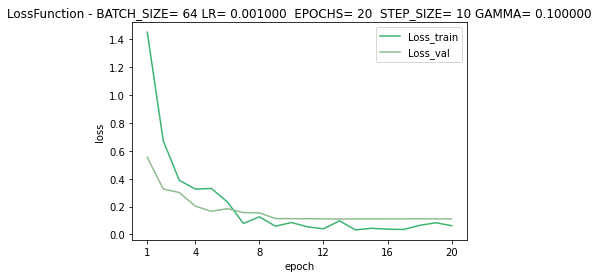

[0.3962655601659751, 0.7897648686030428, 0.8827800829875518, 0.9270401106500692, 0.9553941908713693, 0.969225449515906, 0.9785615491009682, 0.9820193637621023, 0.9840940525587828, 0.9865145228215768, 0.9885892116182573, 0.9892807745504841, 0.9892807745504841, 0.9906639004149378, 0.9892807745504841, 0.9885892116182573, 0.9910096818810512, 0.9892807745504841, 0.989972337482711, 0.9927385892116183]
0.8475103734439834


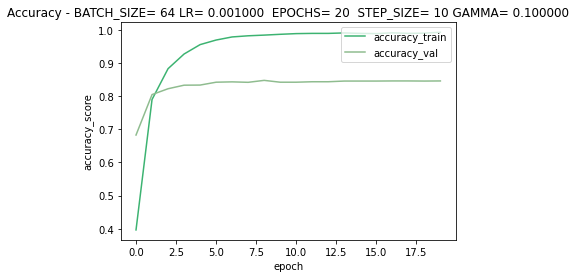

In [10]:
#pedrone

tit = 'LossFunction - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' % (BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
punti=[1,4,8,12,16,20]
x=np.linspace(1,20,20)
plt.plot(x,loss_vector,color='mediumseagreen')
plt.plot(x,loss_val,color='darkseagreen')
plt.title(tit)
plt.xticks(punti)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Loss_train','Loss_val'],loc='upper right')
plt.show()
tit_2='Accuracy - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' %(BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
plt.plot(acc_train,color='mediumseagreen')
plt.plot(tot_accuracy,color='darkseagreen')
plt.legend(['accuracy_train','accuracy_val'],loc='upper right')
plt.title(tit_2)
plt.xlabel('epoch')
plt.ylabel('accuracy_score')
print(acc_train)
print(best_accuracy)

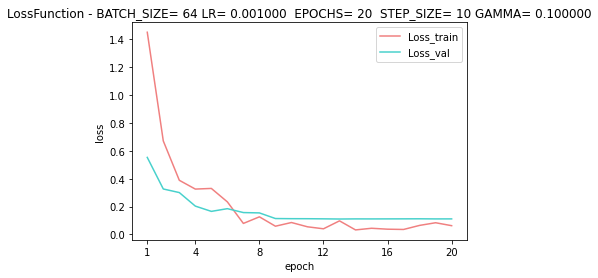

[0.3962655601659751, 0.7897648686030428, 0.8827800829875518, 0.9270401106500692, 0.9553941908713693, 0.969225449515906, 0.9785615491009682, 0.9820193637621023, 0.9840940525587828, 0.9865145228215768, 0.9885892116182573, 0.9892807745504841, 0.9892807745504841, 0.9906639004149378, 0.9892807745504841, 0.9885892116182573, 0.9910096818810512, 0.9892807745504841, 0.989972337482711, 0.9927385892116183]
0.8475103734439834


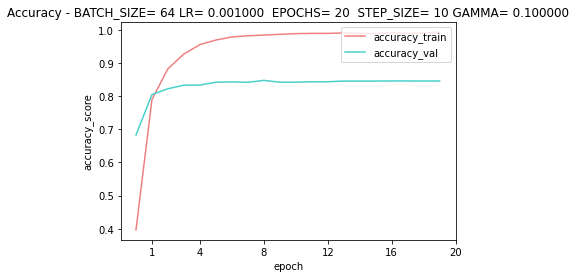

In [11]:
tit = 'LossFunction - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' % (BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
x=np.linspace(1,20,20)
punti=[1,4,8,12,16,20]
plt.plot(x,loss_vector,color='lightcoral')
plt.plot(x,loss_val,color='mediumturquoise')
plt.xticks(punti)
plt.title(tit)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Loss_train','Loss_val'],loc='upper right')
plt.show()
tit_2='Accuracy - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' %(BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
plt.plot(acc_train,color='lightcoral')
plt.plot(tot_accuracy,color='mediumturquoise')
plt.legend(['accuracy_train','accuracy_val'],loc='upper right')
plt.title(tit_2)
plt.xlabel('epoch')
plt.ylabel('accuracy_score')
plt.xticks(punti)
print(acc_train)
print(best_accuracy)

In [12]:
#TEST
net = best_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False)

running_corrects = 0
for images, labels in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

  0%|          | 0/46 [00:00<?, ?it/s]

2893
2893


100%|██████████| 46/46 [00:10<00:00,  4.40it/s]

2893
Test Accuracy: 0.8389215347390252
